# Optimizacion Sharpe via Scipy

In [ ]:
import yfinance as yf
import numpy as np
from scipy import optimize


def sharpe_neg(weights):
    FREE_RISK = 0.045
    global ret_log
    weights = np.array(weights)
    ret = np.sum(ret_log.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(ret_log.cov()*252,weights)))
    sr = (ret-FREE_RISK)/vol
    return -sr

def check_sum(weights):
    return np.sum(weights) -1

In [ ]:
df = yf.download(['GGAL','AAPL','NVDA'], start='2023-01-01', end='2024-01-01')['Adj Close']
df = df.loc[~(df==0).any(axis=1)]
ret_log = np.log((df/df.shift(1)).dropna())

cons = ({'type':'eq','fun':check_sum})
bounds = [(0.05,1)] * len(ret_log.columns)
init_guess = [0.1] * len(ret_log.columns)

opt_results = optimize.minimize(sharpe_neg, init_guess, bounds=bounds, constraints=cons)
opt_results

[*********************100%***********************]  3 of 3 completed


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -5.0144048223320645
       x: [ 6.379e-01  1.372e-01  2.249e-01]
     nit: 8
     jac: [-1.895e-01 -1.890e-01 -1.889e-01]
    nfev: 34
    njev: 8

In [ ]:
(opt_results['x'] * 100).round(2)

array([63.79, 13.72, 22.49])

# Markowitz por montecarlo

## Repaso básico concepto Sharpe Ratio

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

FREE_RISK = 0.045
df = yf.download(['GGAL','AAPL','NVDA'], start='2023-01-01', end='2024-01-01')['Adj Close']
df = df.loc[~(df==0).any(axis=1)]
retornos = np.log((df/df.shift(1)).dropna())

[*********************100%***********************]  3 of 3 completed


In [ ]:
datosTickers = []
for ticker in retornos.columns:
    d = {}
    d['ticker'] = ticker
    d['retorno'] = retornos[ticker].mean() * 252
    d['volatilidad'] = retornos[ticker].std() * (252**0.5)
    d['sharpe'] = (d['retorno']-FREE_RISK) / d['volatilidad']
    datosTickers.append(d)


datosTickers = pd.DataFrame(datosTickers).set_index('ticker')
datosTickers

,retorno,volatilidad,sharpe
ticker,,,
AAPL,0.881843,0.205758,4.067129
GGAL,1.297467,0.585319,2.139802
NVDA,2.207887,0.549840,3.933663


## Simulamos varias composiciones

In [ ]:
%%time

# Vamos a generar 10k carteras al azar
q = 10_000
retornos = np.log((df/df.shift(1)).dropna())
carteras = []

for i in range(q):
    print (f'Simulando portafolio N° {i+1} de {q}     ', end='\r')
    pond = np.array(np.random.random(len(df.columns)))
    pond = pond/np.sum(pond)
    r={}

    # Formula retorno del portafolio: r * w
    r['retorno'] = np.sum( (retornos.mean() * pond * 252))

    # Formula varianza del portafolio wT cov w
    r['volatilidad'] = np.sqrt(np.dot(pond, np.dot(retornos.cov()*252, pond)))
    r['sharpe'] = (r['retorno']-FREE_RISK) / r['volatilidad']
    r['pesos'] = pond.round(4)
    carteras.append(r)

carteras = pd.DataFrame(carteras)
carteras

CPU times: user 24.6 s, sys: 724 ms, total: 25.3 s
Wall time: 40.3 s


,retorno,volatilidad,sharpe,pesos
0,1.270950,0.247833,4.946688,"[0.6526, 0.0787, 0.2688]"
1,1.546590,0.351805,4.268242,"[0.1978, 0.4382, 0.364]"
2,1.652504,0.361071,4.452042,"[0.4035, 0.0223, 0.5742]"
3,1.392960,0.513629,2.624385,"[0.0227, 0.862, 0.1153]"
4,1.408592,0.281811,4.838677,"[0.4335, 0.2465, 0.32]"
...,...,...,...,...
9995,1.639745,0.356538,4.472856,"[0.1782, 0.3645, 0.4573]"
9996,1.565503,0.383273,3.967151,"[0.1227, 0.5268, 0.3504]"
9997,1.455269,0.315497,4.469997,"[0.3115, 0.373, 0.3155]"
9998,1.511683,0.305535,4.800372,"[0.4359, 0.1298, 0.4343]"


## Extraigo la mejor combinación

In [ ]:
optimo = carteras.loc[carteras['sharpe'].idxmax()]
mejor_port = carteras.iloc[carteras['sharpe'].idxmax()]['pesos']

datosTickers['ponderacion_optima'] = mejor_port
datosTickers

,retorno,volatilidad,sharpe,ponderacion_optima
ticker,,,,
AAPL,0.881843,0.205758,4.067129,0.6531
GGAL,1.297467,0.585319,2.139802,0.1303
NVDA,2.207887,0.549840,3.933663,0.2166


In [ ]:
# Recordemos que los ratios sharpe individuales eran: 4.06, 2.13, 3.93
carteras['sharpe'].max()

5.013185454274824

In [ ]:
datosTickers.ponderacion_optima

ticker
AAPL    0.6531
GGAL    0.1303
NVDA    0.2166
Name: ponderacion_optima, dtype: float64

## Graficamos

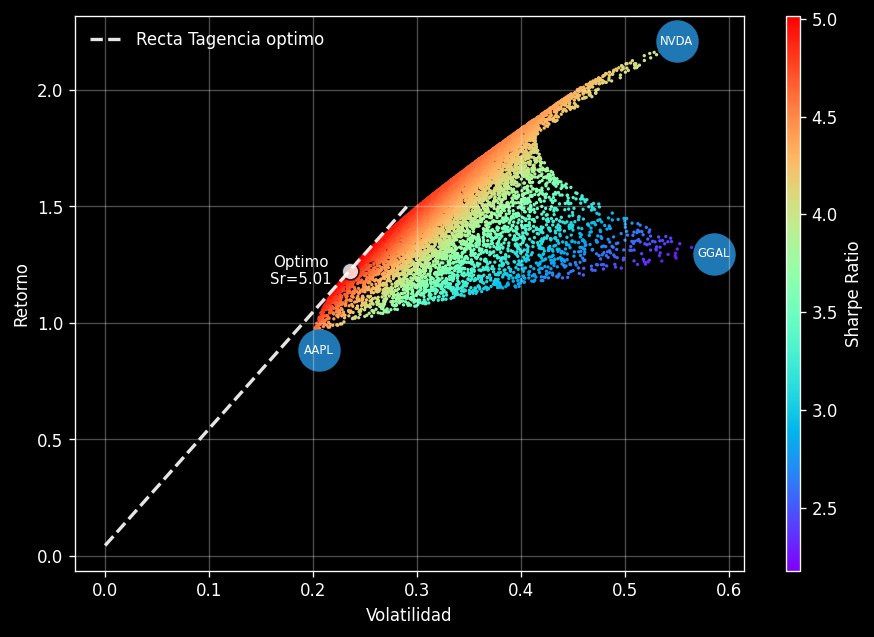

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 120
fig, ax = plt.subplots(figsize=(9,6))
chart = ax.scatter(carteras.volatilidad, carteras.retorno, c=carteras['sharpe'], s=1, cmap='rainbow')

fig.colorbar(chart, label='Sharpe Ratio', aspect=40)
ax.set_xlabel('Volatilidad')
ax.set_ylabel('Retorno')

optimo_txt = f'Optimo\nSr={carteras["sharpe"].max():.2f}'
ax.scatter(optimo.volatilidad, optimo.retorno, c='white', alpha=0.8, edgecolors='black', s=100)
ax.text(optimo.volatilidad*0.8, optimo.retorno, optimo_txt, fontsize=9, c='white', ha='center', va='center')

for ticker in df.columns:
    vol = datosTickers.loc[ticker,'volatilidad']
    ret = datosTickers.loc[ticker,'retorno']
    ax.scatter(vol, ret,  c='tab:blue', s=600)
    ax.text(vol, ret, ticker, fontsize=7, c='w', ha='center', va='center')

m = (optimo.retorno - FREE_RISK) /  optimo.volatilidad
tg = [m * x + FREE_RISK for x in [i/100 for i in range(30)]]
ax.plot([i/100 for i in range(30)], tg, c='white', lw=2, ls='--', alpha=0.9, label='Recta Tagencia optimo')
ax.legend(frameon=False)
ax.grid(alpha=0.3)

# NCO

In [ ]:
import warnings

warnings.filterwarnings("ignore")
#pd.options.display.float_format = '{:.4%}'.format

start = '2021-01-01'
end = '2023-12-30'

assets = ['GGAL','BBAR','BMA','SUPV',
          'LOMA','CRESY','TEO',
          'MELI','BTC-USD','ETH-USD',
          'BABA','KO','VZ','SQQQ','SH','SDOW']
assets.sort()

data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets
Y = data[assets].pct_change().dropna()

[*********************100%***********************]  16 of 16 completed


In [ ]:
pip install Riskfolio-Lib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 23.2 MB/s eta 0:00:00


<Axes: >

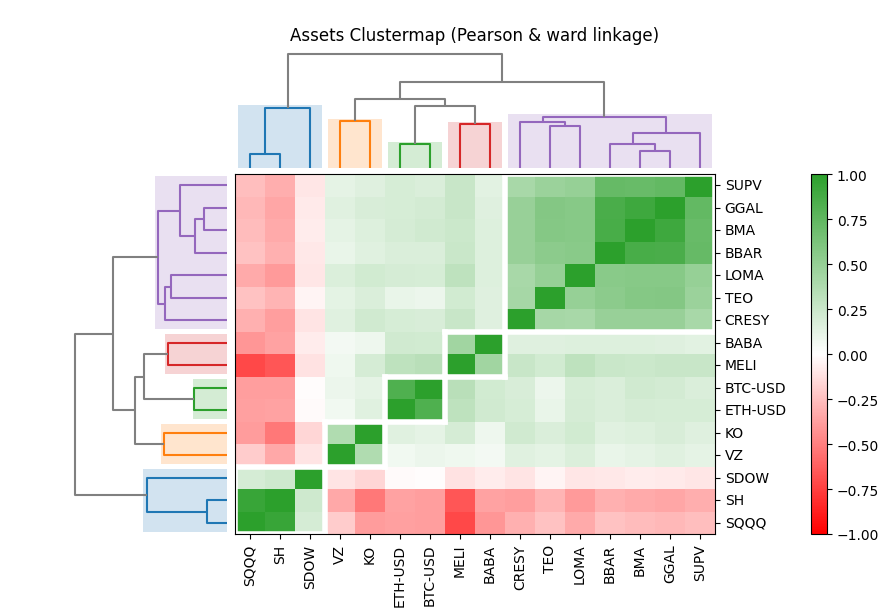

In [ ]:
import riskfolio as rp
import matplotlib as mpl
import matplotlib.pyplot as plt
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["red", "white", "tab:green"])

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,6))
rp.plot_clusters(returns=Y,
                      codependence='pearson',
                      linkage='ward',
                      cmap= cmap,
                      k=5,
                      leaf_order=True,
                      dendrogram=True,
                      linecolor='white',
                      ax=ax)

## Medidas del riesgo para el parametro "rm"

| Clave       | Descripción                                                             |
|-------------|-------------------------------------------------------------------------|
| 'vol'       | Desviación estándar                                                     |
| 'MV'        | Varianza                                                                |
| 'KT'        | Curtosis cuadrada de la raíz                                             |
| 'MAD'       | Desviación media absoluta                                                |
| 'MSV'       | Desviación estándar semivariante                                         |
| 'SKT'       | Semicurtosis cuadrada de la raíz                                          |
| 'FLPM'      | Primer momento parcial inferior (Ratio Omega)                            |
| 'SLPM'      | Segundo momento parcial inferior (Ratio Sortino)                         |
| 'VaR'       | Valor en riesgo                                                         |
| 'CVaR'      | Valor en riesgo condicional                                             |
| 'TG'        | Gini de cola                                                            |
| 'EVaR'      | Valor en riesgo entrópico                                                |
| 'RLVaR'     | Valor en riesgo relativista                                              |
| 'WR'        | Peor realización (Minimax)                                               |
| 'RG'        | Rango de rendimientos                                                    |
| 'CVRG'      | Rango de rendimientos de valor en riesgo condicional                     |
| 'TGRG'      | Rango de rendimientos de Gini de cola                                     |
| 'MDD'       | Pérdida máxima en relación a los rendimientos acumulados sin compensar    |
| 'ADD'       | Pérdida promedio en relación a los rendimientos acumulados sin compensar  |
| 'DaR'       | Pérdida en relación al riesgo de los rendimientos acumulados sin compensar|
| 'CDaR'      | Pérdida en relación al riesgo condicional de los rendimientos acumulados sin compensar |
| 'EDaR'      | Pérdida en relación al riesgo entrópico de los rendimientos acumulados sin compensar |
| 'RLDaR'     | Pérdida en relación al riesgo relativista de los rendimientos acumulados sin compensar |
| 'UCI'       | Índice de úlcera de los rendimientos acumulados sin compensar              |
| 'MDD_Rel'   | Pérdida máxima en relación a los rendimientos acumulados compensados      |
| 'ADD_Rel'   | Pérdida promedio en relación a los rendimientos acumulados compensados    |
| 'DaR_Rel'   | Pérdida en relación al riesgo de los rendimientos acumulados compensados  |
| 'CDaR_Rel'  | Pérdida en relación al riesgo condicional de los rendimientos acumulados compensados |
| 'EDaR_Rel'  | Pérdida en relación al riesgo entrópico de los rendimientos acumulados compensados |
| 'RLDaR_Rel' | Pérdida en relación al riesgo relativista de los rendimientos acumulados compensados |
| 'UCI_Rel'   | Índice de úlcera de los rendimientos acumulados compensados                |


In [ ]:
# Creamos el portafolio por el metodo NCO
port = rp.HCPortfolio(returns=Y)

model='NCO' # podrian ser HRP, HERC or NCO
            # 'HRP': Hierarchical Risk Parity. (castiga clusteres de mayor riesgo)
            # 'HERC': Hierarchical Equal Risk Contribution. (pondera de modo que todos los activos contribuyan igual en riesgo)
            # 'HERC2': HERC pero pesos flat dentro de los clusters.


codependence = 'pearson' # el tipo de correlacion a usar
covariance = 'hist' # Opciones: ewma1, ewma2, ledoit, oas, shrunk, gl, jlogo, fixed, spectral, shrink, gerber1, gerber2, custom_cov
obj = "MinRisk" #  Otros: 'Utility', 'Sharpe' or 'ERC'
rm = 'MV' # Ver tabla
FREE_RISK = 0.045
l = 2 # Factor de aversion al riesgo (para cuando el objetivo es la utilidad)
linkage = 'ward' # Metodo usado para construir los clusteres (single, complete, average, etc)
max_k = 10 # Max numero de clusters

w = port.optimization(model=model,
                      codependence=codependence,
                      covariance=covariance,
                      obj=obj,
                      rm=rm,
                      rf=FREE_RISK,
                      l=l,
                      linkage=linkage,
                      max_k=max_k)
w

,weights
BABA,3.876452e-02
BBAR,4.234374e-10
BMA,4.228080e-09
BTC-USD,2.788776e-02
CRESY,6.087706e-03
ETH-USD,4.676721e-10
GGAL,1.554666e-03
KO,2.424131e-01
LOMA,2.657915e-02
MELI,2.962892e-02


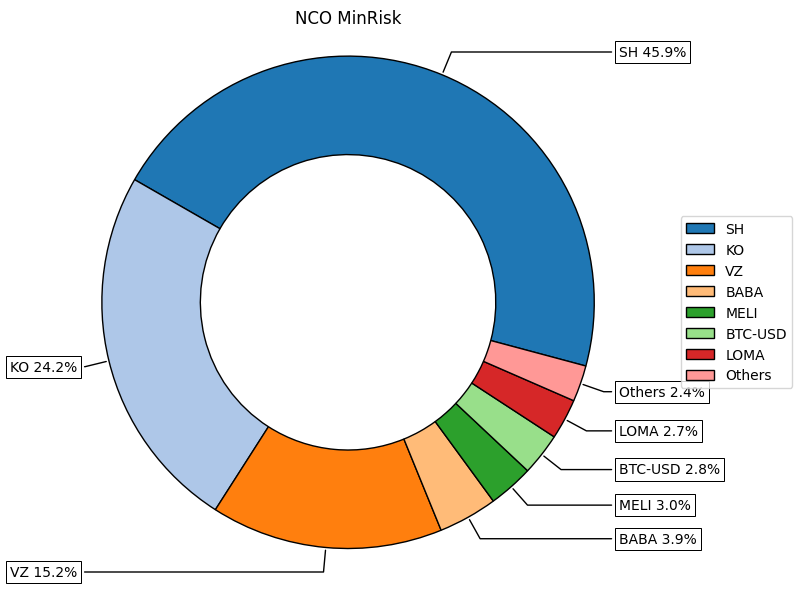

In [ ]:
ax = rp.plot_pie(w=w,
                 title='NCO MinRisk',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=6,
                 width=8,
                 ax=None)

## NCO: Contribucion al riesgo por activo

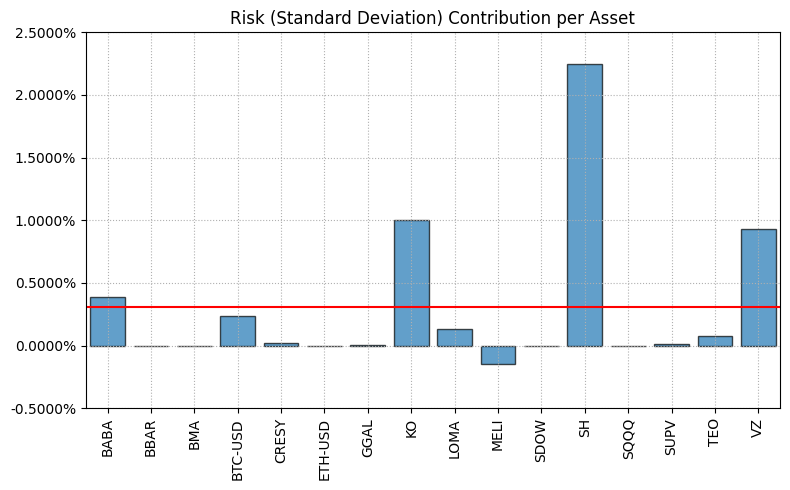

In [ ]:
mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=5,
                      width=8,
                      t_factor=252,
                      ax=None)

## NCO con restricciones

In [ ]:
asset_classes = {'Assets': ['GGAL','BBAR','BMA','SUPV', 'LOMA','CRESY','TEO',
                            'MELI','BTC-USD','ETH-USD', 'BABA','KO','VZ','SQQQ','SH','SDOW'],
                 'Industry': ['ADR Banco','ADR Banco',
                              'ADR Banco', 'ADR Banco',
                              'ADR Otros','ADR Otros','ADR Otros',
                              'Marketplaces','Cryptos','Cryptos',
                              'Marketplaces','USA Conservador','USA Conservador','Shorts',
                              'Shorts','Shorts']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False, False, False],
               'Type': ['Assets', 'Assets', 'All Assets', 'Each asset in a class', 'Each asset in a class'],
               'Set': ['', '', '','Industry', 'Industry'],
               'Position': ['TEO', 'SQQQ', '', 'Cryptos', 'ADR Bancos'],
               'Sign': ['>=', '<=', '<=', '>=', '<='],
               'Weight': [0.05, 0.03, 0.15, 0.02, 0.06]}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight
0,False,Assets,,TEO,>=,0.05
1,False,Assets,,SQQQ,<=,0.03
2,False,All Assets,,,<=,0.15
3,False,Each asset in a class,Industry,Cryptos,>=,0.02
4,False,Each asset in a class,Industry,ADR Bancos,<=,0.06


In [ ]:
w_max, w_min = rp.hrp_constraints(constraints, asset_classes)

port.w_max = w_max
port.w_min = w_min

w_1 = port.optimization(model=model,
                        codependence=codependence,
                        covariance=covariance,
                        obj=obj,
                        rm=rm,
                        rf=FREE_RISK,
                        l=l,
                        linkage=linkage,
                        max_k=max_k)

display(w_1.T)

,BABA,BBAR,BMA,BTC-USD,CRESY,ETH-USD,GGAL,KO,LOMA,MELI,SDOW,SH,SQQQ,SUPV,TEO,VZ
weights,0.139921,1.528402e-09,1.526130e-08,0.100661,0.021974,0.02,0.005612,0.15,0.095938,0.106946,7.610136e-09,0.15,3.150568e-09,0.008949,0.05,0.15


<Axes: title={'center': 'NCO MinRisk c/restricciones'}>

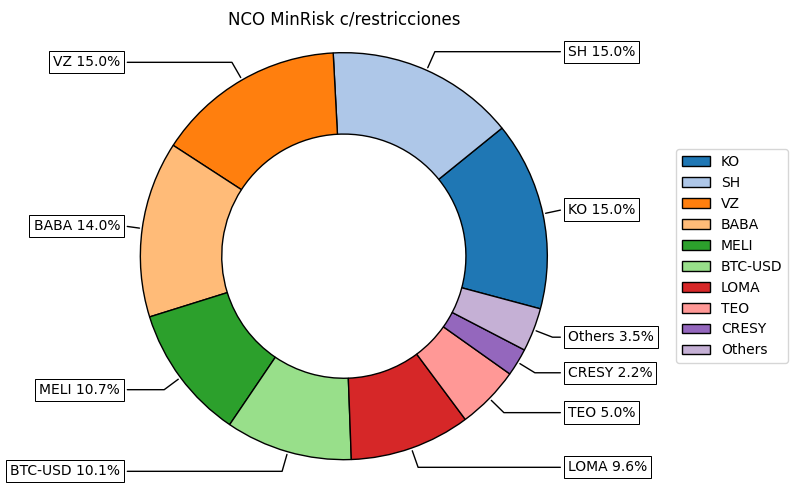

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,5))
rp.plot_pie(w=w_1, title='NCO MinRisk c/restricciones', others=0.05, nrow=25, cmap="tab20", height=8, width=10, ax=ax)

## NCO con restricciones. Contribucion al riesgo por activo

<Axes: title={'center': 'Risk (Standard Deviation) Contribution per Asset'}>

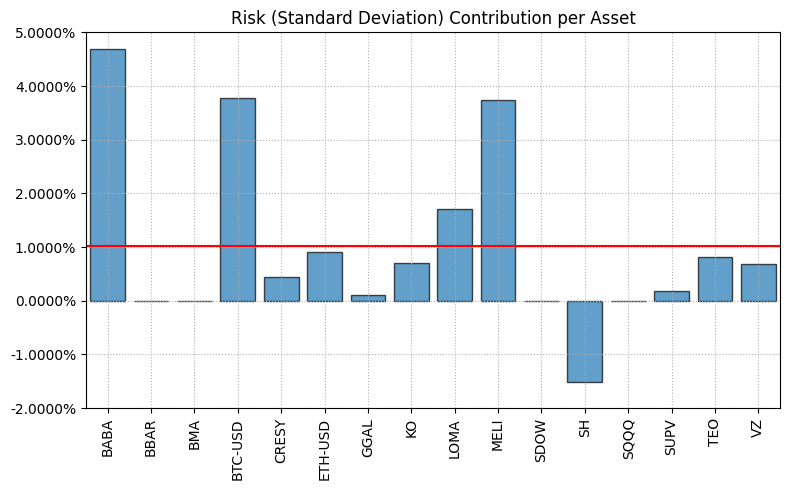

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
rp.plot_risk_con(w=w_1, cov=Y.cov(), returns=Y, rm=rm, rf=FREE_RISK, alpha=0.05, color="tab:blue", height=6, width=10, t_factor=252, ax=ax)

# Black Litterman

In [ ]:
!pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
prices = data
market_prices = yf.download("SPY", start="2021-01-01")["Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [ ]:
mcaps = {}
for t in assets:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info.get("marketCap", 10**10)
mcaps

{'BABA': 215429382144,
 'BBAR': 1264226944,
 'BMA': 4285050112,
 'BTC-USD': 598027927552,
 'CRESY': 922702400,
 'ETH-USD': 232994373632,
 'GGAL': 5115243520,
 'KO': 261983059968,
 'LOMA': 1598608000,
 'MELI': 59935322112,
 'SDOW': 10000000000,
 'SH': 10000000000,
 'SQQQ': 10000000000,
 'SUPV': 587807744,
 'TEO': 3547010560,
 'VZ': 156724740096}

In [ ]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.50753289547891

In [ ]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

BABA       0.156013
BBAR       0.040820
BMA        0.043862
BTC-USD    0.392401
CRESY      0.042772
ETH-USD    0.257909
GGAL       0.043073
KO         0.141300
LOMA       0.037131
MELI       0.091038
SDOW       0.019363
SH         0.009201
SQQQ      -0.036763
SUPV       0.041188
TEO        0.033227
VZ         0.093876
dtype: float64

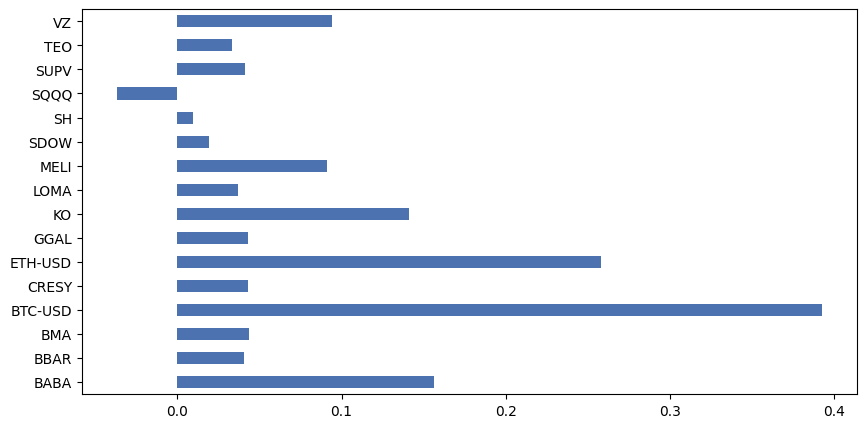

In [ ]:
market_prior.plot.barh(figsize=(10,5));

In [ ]:
viewdict = {
    'BMA': 0.25, # vision alcista BMA +25%
    'LOMA': 0.4, # muy alcista para LOMA + 40%
    'CRESY': 0.0, # view neutra
    'TEO': 0.05,  # view levementa alcista para Telecom
    'MELI': -0.1, # Bajista para Meli
    'BTC-USD': 0.25, # Alcista para BTC, poco menos para ETH
    'ETH-USD': 0.2,
    'BABA': 0.15, # Alcista para Alibaba +15%
    'KO': 0.0,
    'VZ': 0.0,
    'SQQQ': 0.08, # vision bajista para el nasdaq
    'SH': -0.03,  # vision alcista leve para sp500
    'SDOW': -0.07 # vision alcista para el dow
}

confidences = [
    0.3, # BMA
    0.5, # LOMA
    0.5, # CRESY
    0.5, # TEO
    0.8, # MELI
    0.2, # BTC.  En BTC y ETH son en los que estoy mas inseguro de mi view
    0.2, # ETH
    0.8, # BABA
    0.9, # KO.  En coca cola y verizon son en los que mas confianza tengo de mi view
    0.9, # VZ
    0.8, # SQQQ
    0.8, # SH
    0.8, # SDOW
]

"""
Les dejo ejemplos de views relativas, la lib permite o relativas o absolutas,
asi que para meter ambas habria que transformar las absolutas en relativas
contra un activo de referencia al que le damos view neutral por ejemplo
Si quisieramos pasar las views relativas debemos poner el karg absolute_views=False
y pasar P=P y Q=Q como views y mapeo, y por supuesto las view_confidences de la misma dimension
"""
# view relativa 1: GGAL > SUPV + 11%
# view relativa 1: GGAL > BBAR + 7%
P = np.zeros((2, len(assets)))
P[0, assets.index('GGAL')] = 1
P[0, assets.index('SUPV')] = -1
P[1, assets.index('GGAL')] = 1
P[1, assets.index('BBAR')] = -1

# Matriz Q para las vistas relativas
Q = np.array([0.11, 0.07])



bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict,
                         omega="idzorek", view_confidences=confidences)

## Calculo de omega

<Axes: title={'center': 'Omega'}>

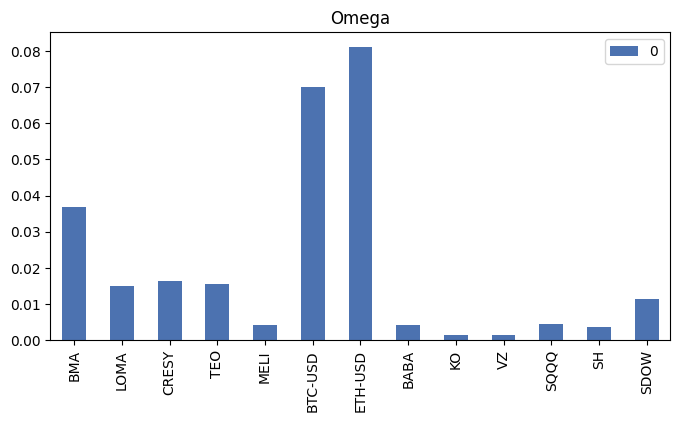

In [ ]:
omega = bl.omega
pd.DataFrame(np.diag(omega), index=viewdict.keys()).plot(kind='bar', figsize=(8,4), title='Omega')

## Estimacion de retornos a posteriori

In [ ]:
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=bl.omega)

ret_bl = bl.bl_returns() # Estimacion de los retornos a posteriori

rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
BABA,0.156013,0.144619,0.15
BBAR,0.040820,0.031355,NaN
BMA,0.043862,0.093200,0.25
BTC-USD,0.392401,0.339582,0.25
CRESY,0.042772,0.012942,0.00
ETH-USD,0.257909,0.217259,0.20
GGAL,0.043073,0.032182,NaN
KO,0.141300,0.012004,0.00
LOMA,0.037131,0.205844,0.40
MELI,0.091038,-0.066560,-0.10


<Axes: >

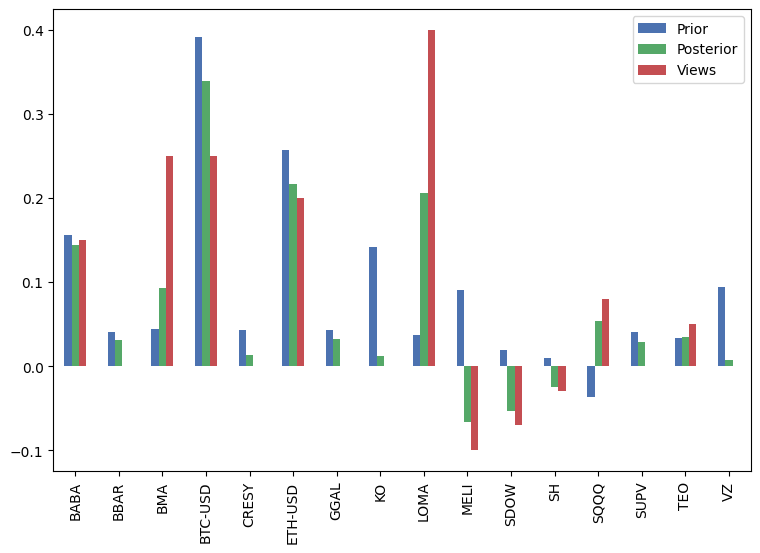

In [ ]:
rets_df.plot.bar(figsize=(9,6))

## Optimizacion por sharpe basado en retornos a posteriori de BL

In [ ]:
from pypfopt import EfficientFrontier, objective_functions

S_bl = bl.bl_cov()
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

In [ ]:
pd.DataFrame([weights]).T

,0
BABA,0.13204
BBAR,0.00262
BMA,0.07339
BTC-USD,0.33330
CRESY,0.00000
ETH-USD,0.18317
GGAL,0.00379
KO,0.00000
LOMA,0.20540
MELI,0.00000


<Axes: title={'center': 'BL'}>

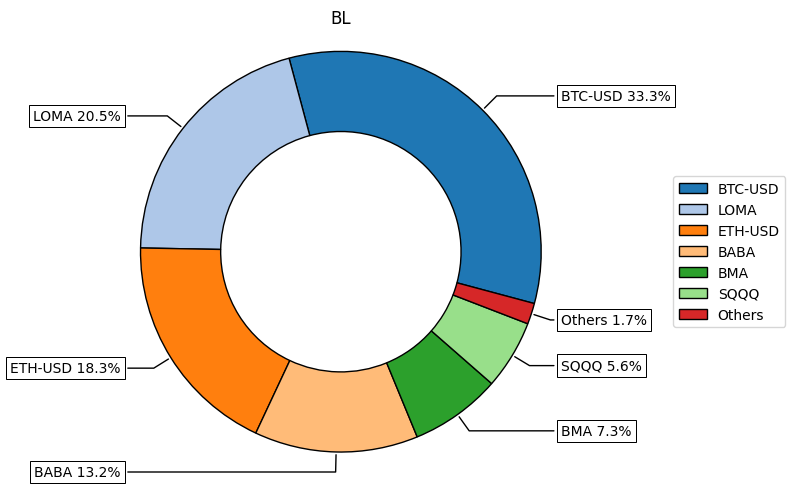

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
rp.plot_pie(w=pd.DataFrame([weights]).T, title='BL', others=0.05, nrow=25, cmap="tab20", height=8, width=10, ax=ax)